In [14]:
import pandas as pd
import numpy as np
from pathlib import Path
import datetime as dt
import os
import scipy as sp
## pls excuse
import os, sys
up1 = os.path.abspath('..'); sys.path.insert(0, up1)
## pls excuse

dataDF = pd.read_csv(Path(os.getcwd()).parent / 'data' / 'assets' / 'featurized_all_5min.csv', parse_dates=['time', 'basetime'], dtype={'patient_id': str})
rhythmDF = pd.read_csv('stitched_annotations.csv', parse_dates=['start', 'stop'], dtype={'id': str})

def categorizeByRhythm(data: pd.DataFrame, rhythmReference: pd.DataFrame, priorPoint = dt.timedelta(hours=2), periodIncrements = dt.timedelta(minutes=30)):
    result = list()
    for patient_id, id_group in rhythmReference.groupby('id'):
        dataFiltered = data[data['patient_id'] == patient_id]
        for i, ann in id_group.iterrows():
            pointsInternal = dataFiltered[(ann['start'] <= dataFiltered['time'])& (dataFiltered['time'] <= ann['stop'])].copy()
            pointsPrior = None
            if ann['rhythm'] == 'sinus':
                #add to points internal
                pointsInternal['period'] = 'stable'
            elif ann['rhythm'] == 'atrial_fibrillation':
                #add to points internal
                pointsInternal['period'] = 'afib_internal'
                # define points prior
                priorPointsList = list()
                for priorPointIdx in range(int(priorPoint / periodIncrements)):
                    start, end = (priorPointIdx+1)*periodIncrements, priorPointIdx*periodIncrements
                    strStart, strEnd = int(start.total_seconds() // 60), int(end.total_seconds() // 60)
                    start, end = ann['start'] - start, ann['start'] - end
                    pointsPrior = dataFiltered[(start <= dataFiltered['time']) & (dataFiltered['time'] <= end)].copy()
                    pointsPrior['period'] = f'afib_prior_{strEnd}_to_{strStart}_minutes'
                    priorPointsList.append(pointsPrior)
                pointsPrior = pd.concat(priorPointsList)
                # twoHoursPrior = ann['start'] - dt.timedelta(hours=2)
                # pointsPrior = dataFiltered[(twoHoursPrior <= dataFiltered['time']) & (dataFiltered['time'] <= ann['start'])].copy()
                # pointsPrior['period'] = 'afib_prior'
            result.append(pointsInternal)
            if (type(pointsPrior) != type(None)):
                result.append(pointsPrior)
    return pd.concat(result)
categorized = categorizeByRhythm(dataDF, rhythmDF)

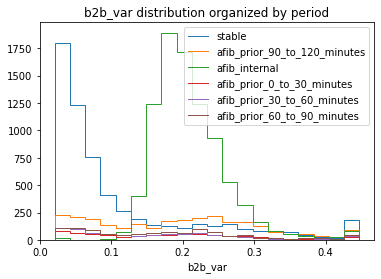

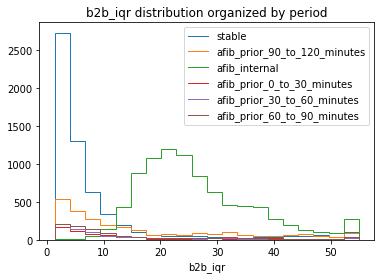

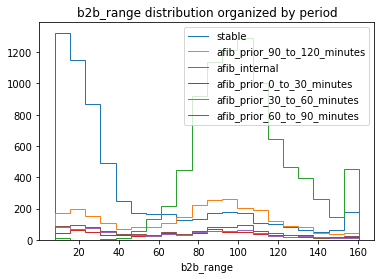

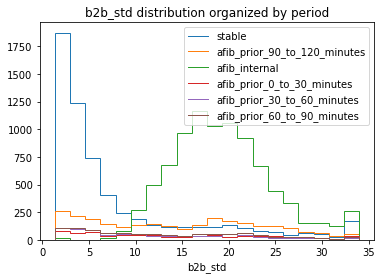

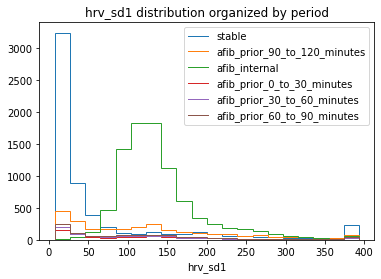

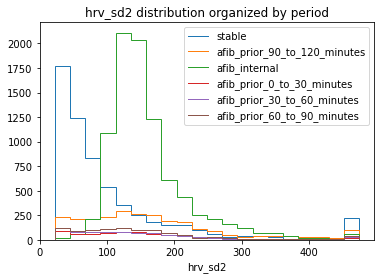

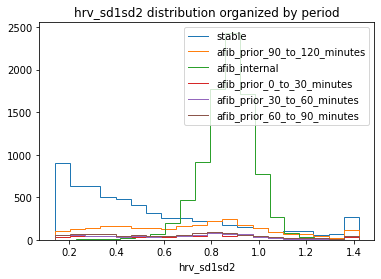

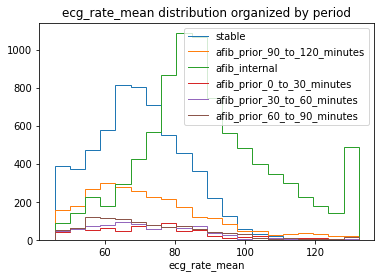

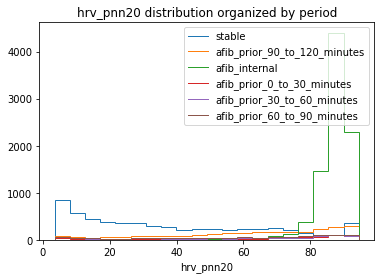

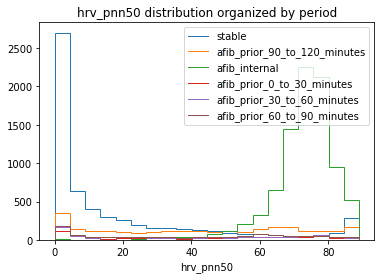

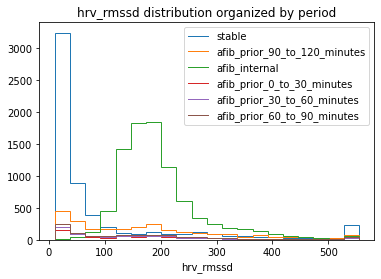

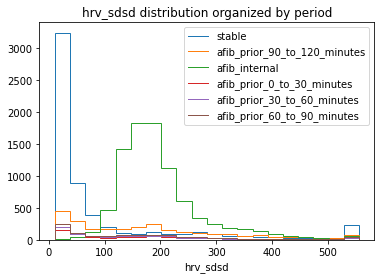

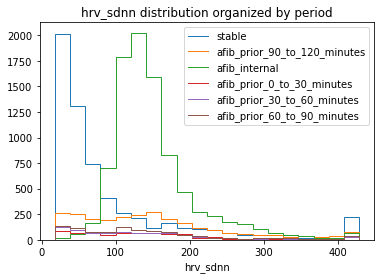

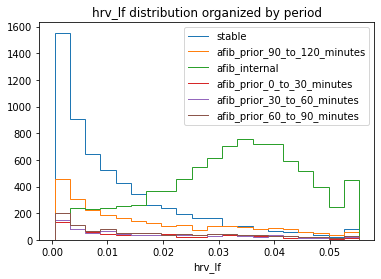

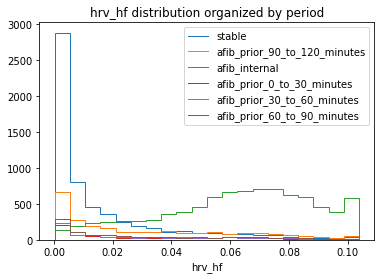

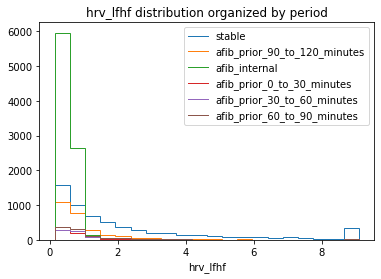

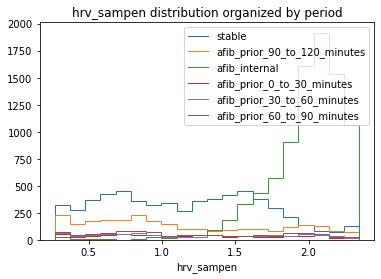

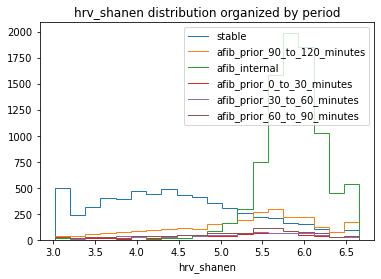

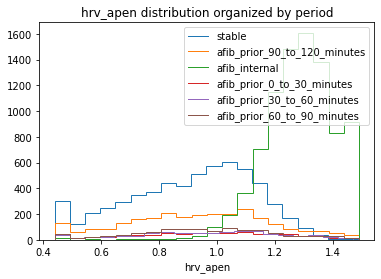

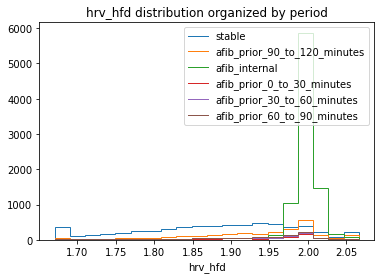

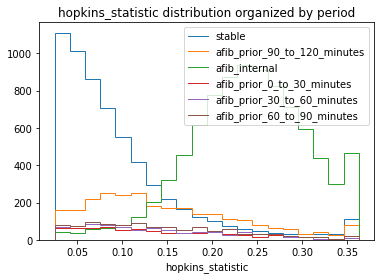

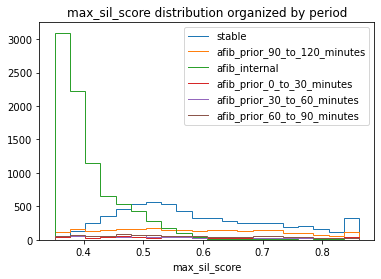

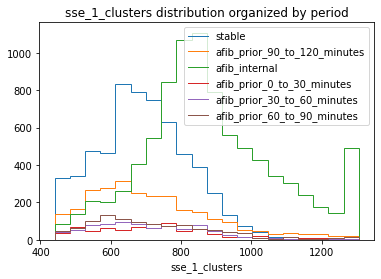

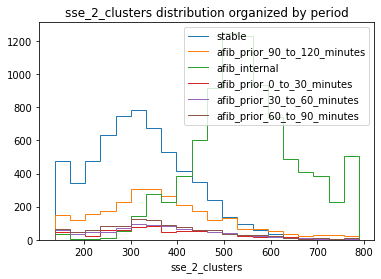

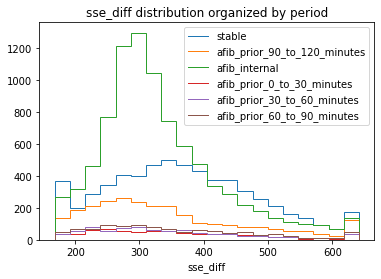

In [15]:
import matplotlib.pyplot as plt
import scipy as sp
NUM_BINS=20
%matplotlib inline
def showHistogramForFeature(feat, df):
    df = df.copy()
    # first winsorize all data
    df[feat] = sp.stats.mstats.winsorize(df[feat], limits=[.02, .02])
    for period in df['period'].unique():
        counts, bins = np.histogram(df[df['period'] == period][feat], bins=NUM_BINS)
        plt.stairs(counts, bins, label=period)
    plt.title(f'{feat} distribution organized by period')
    plt.legend()
    plt.xlabel(feat)
    plt.show()
from data.utilities import getDataConfig
for feat in getDataConfig().features_nk:
    showHistogramForFeature(feat, categorized.copy().drop_duplicates(subset=dataDF.columns, keep='last'))

/tmp/ipykernel_2040207/149457390.py:8: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure()


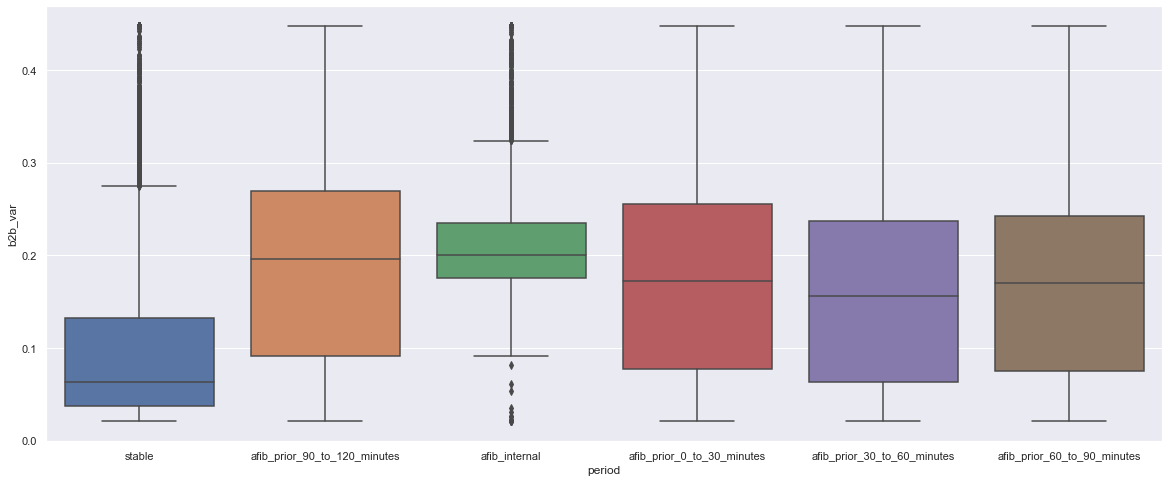

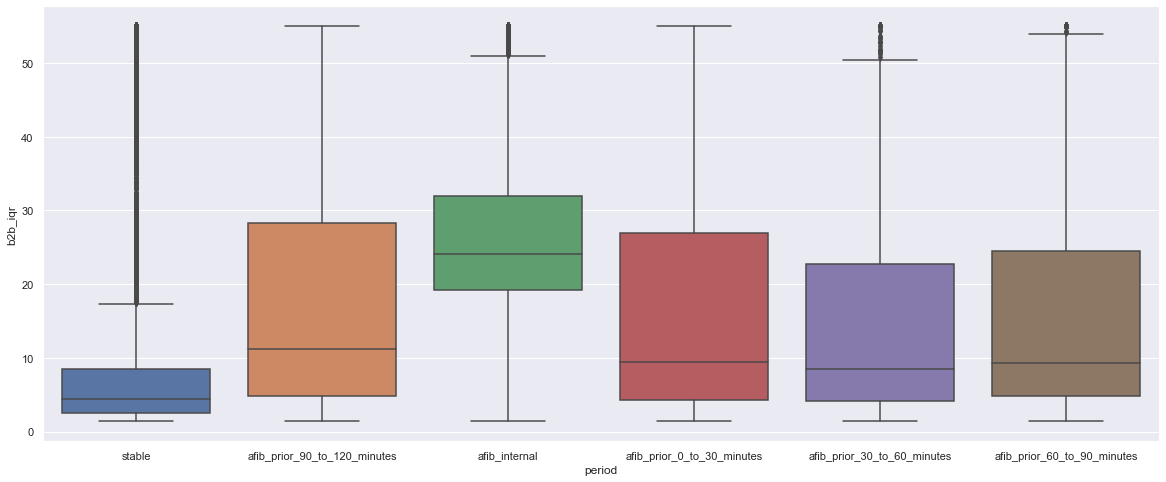

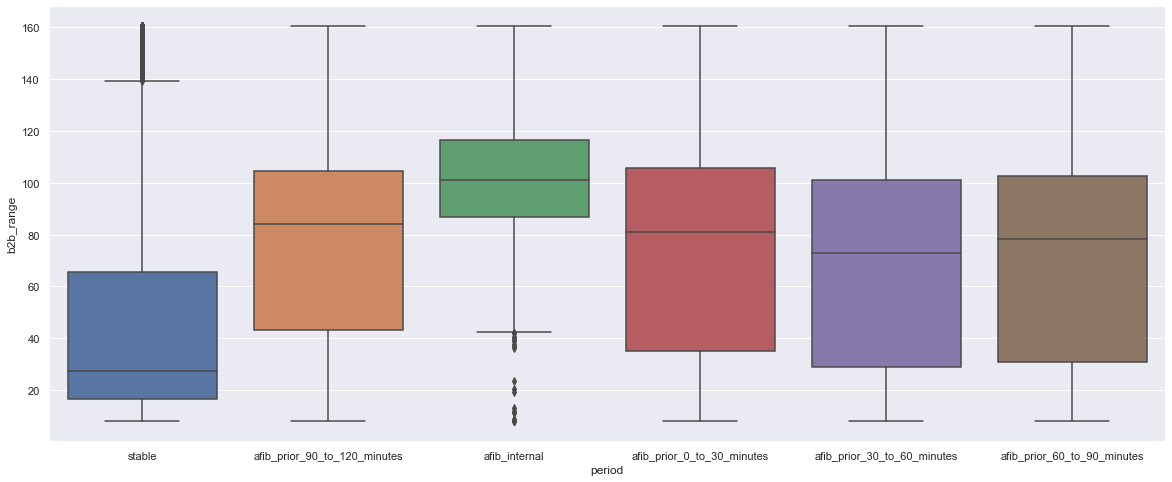

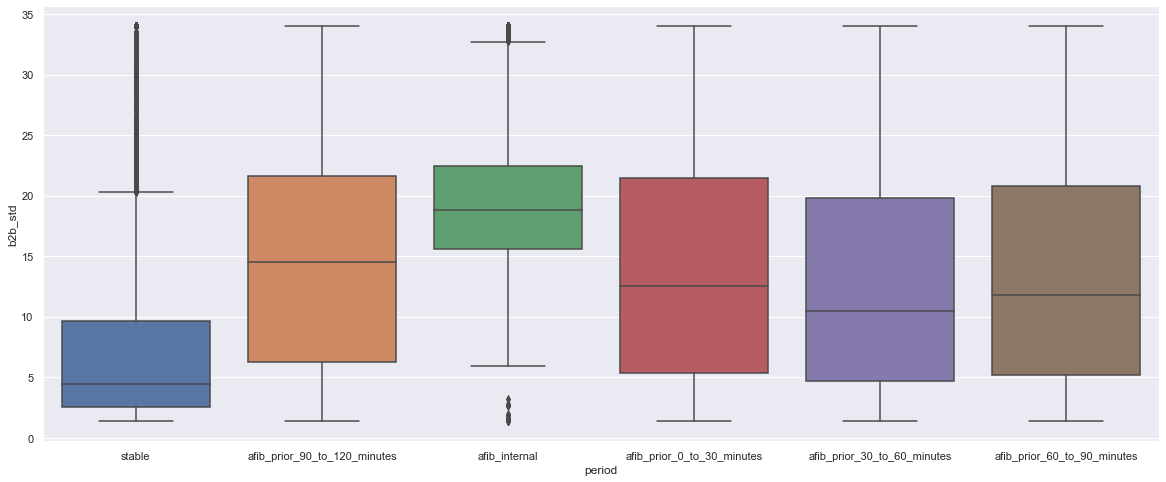

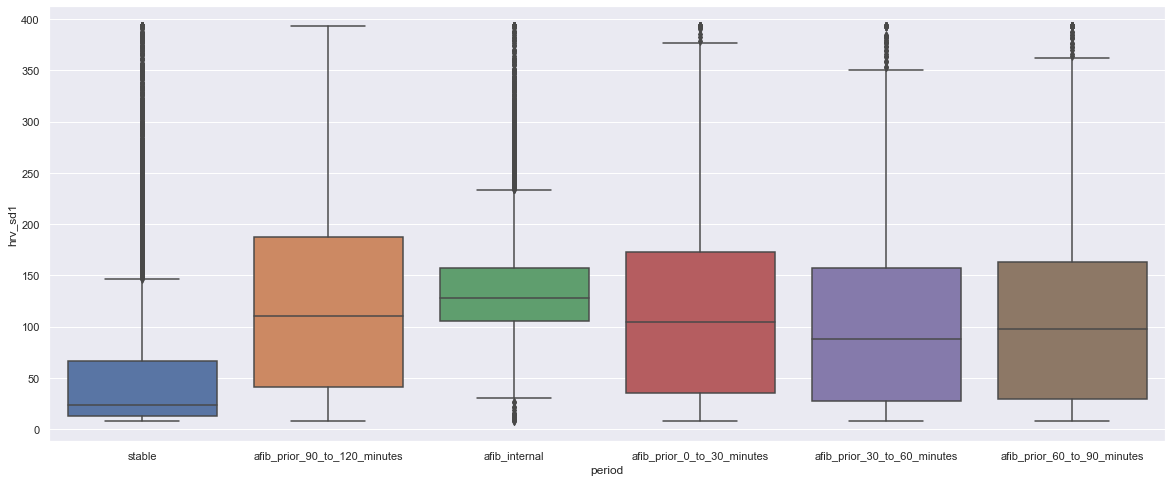

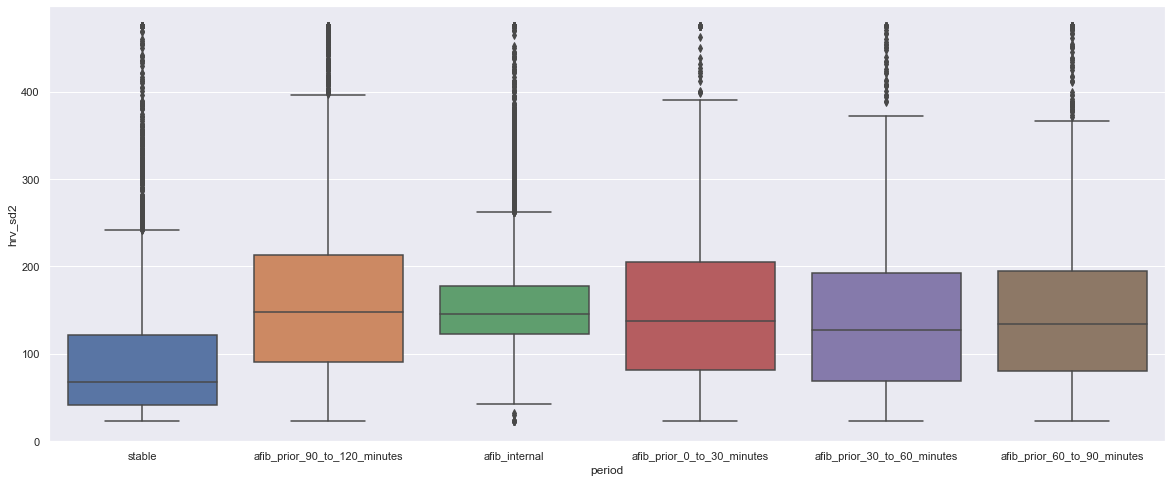

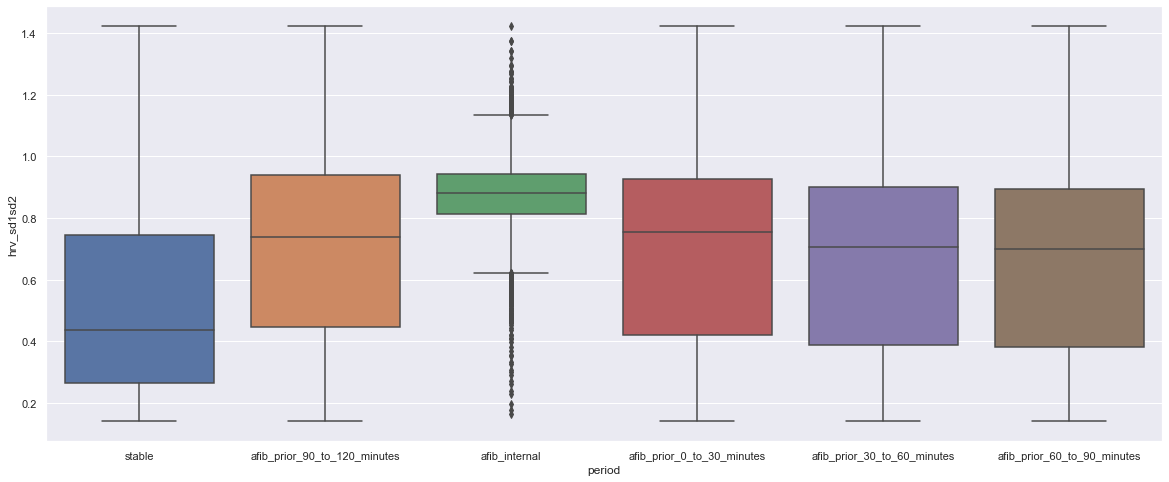

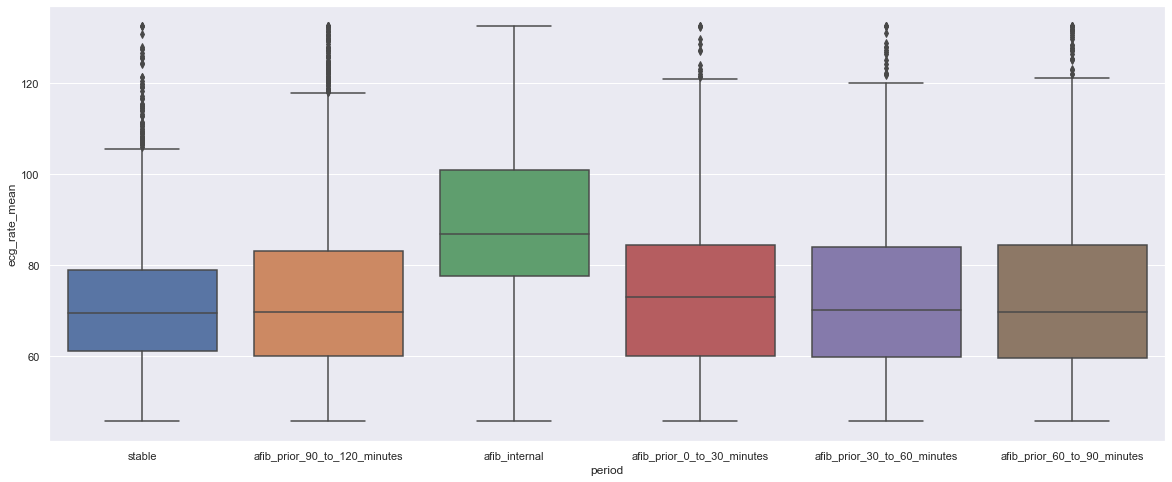

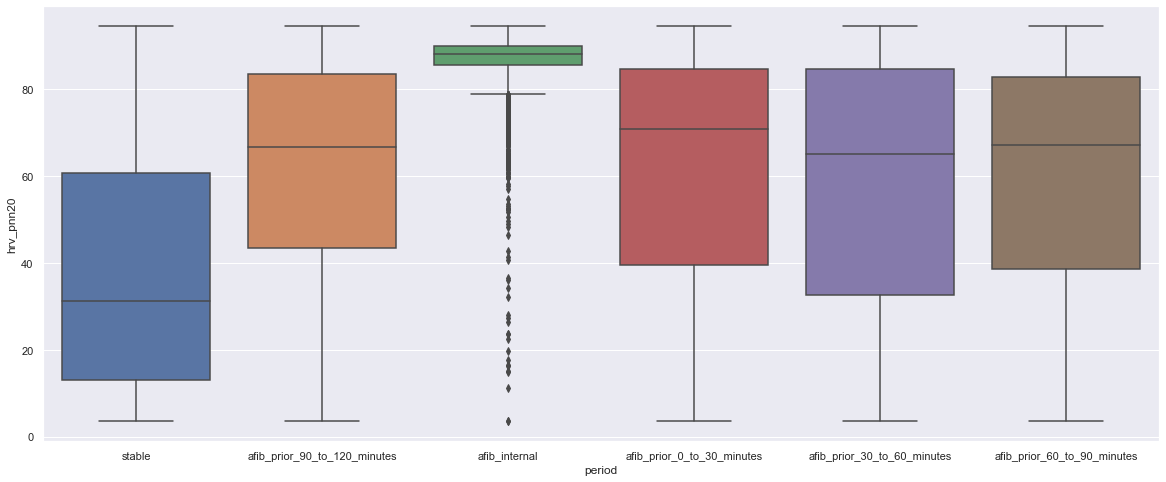

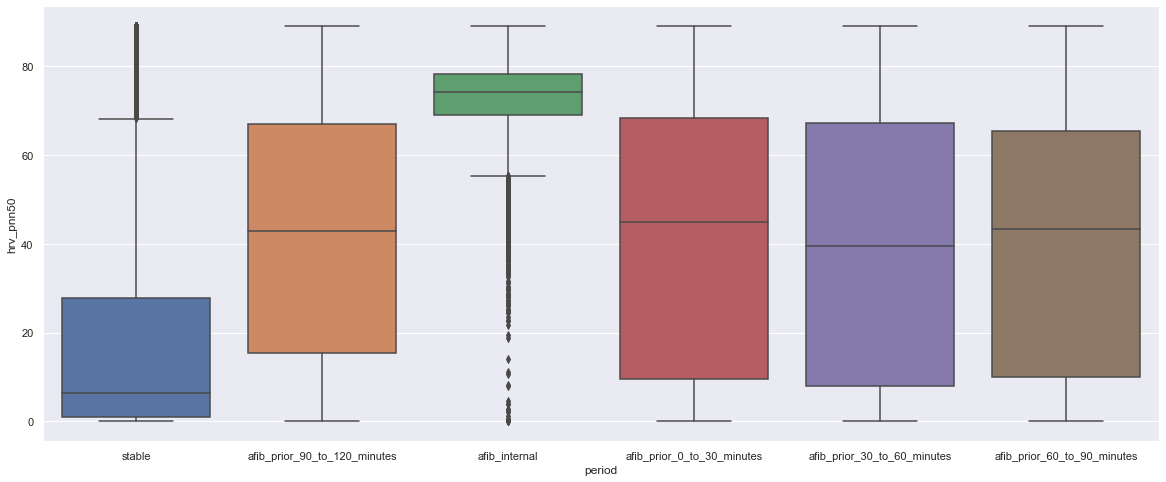

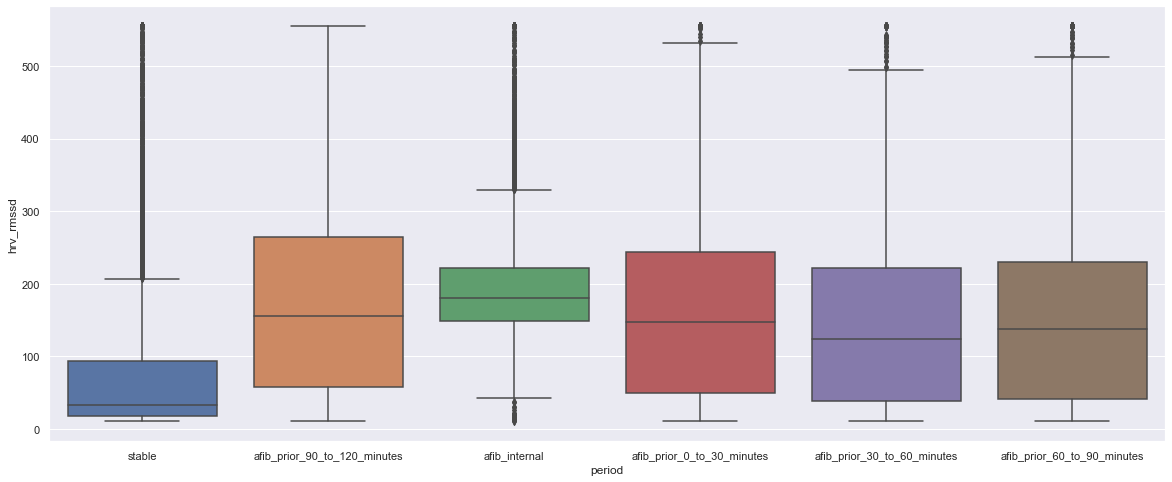

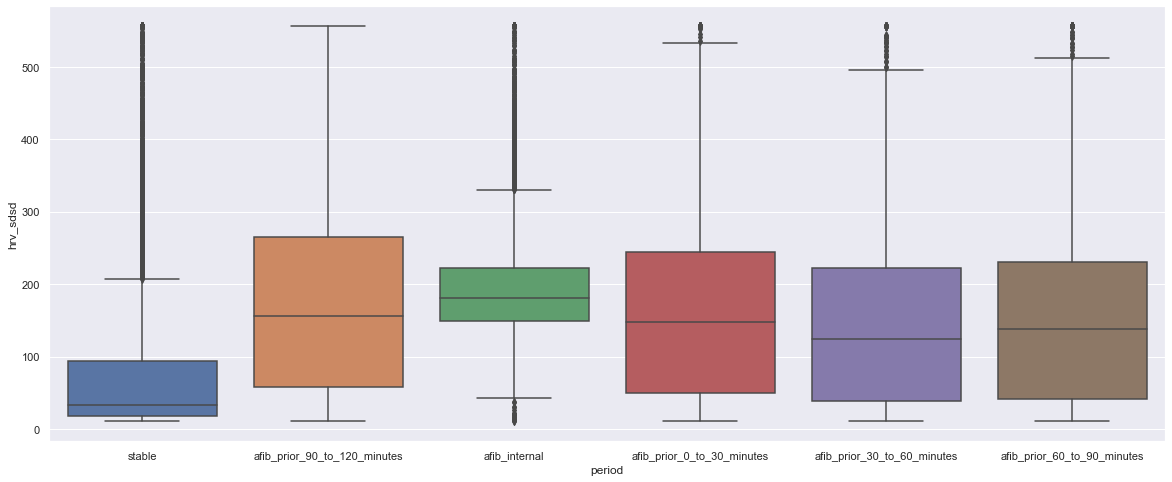

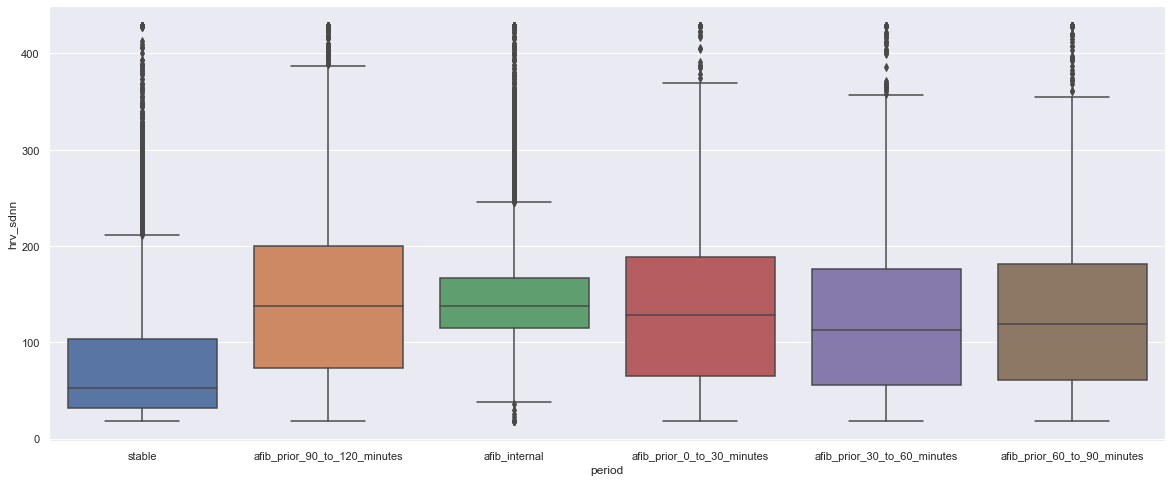

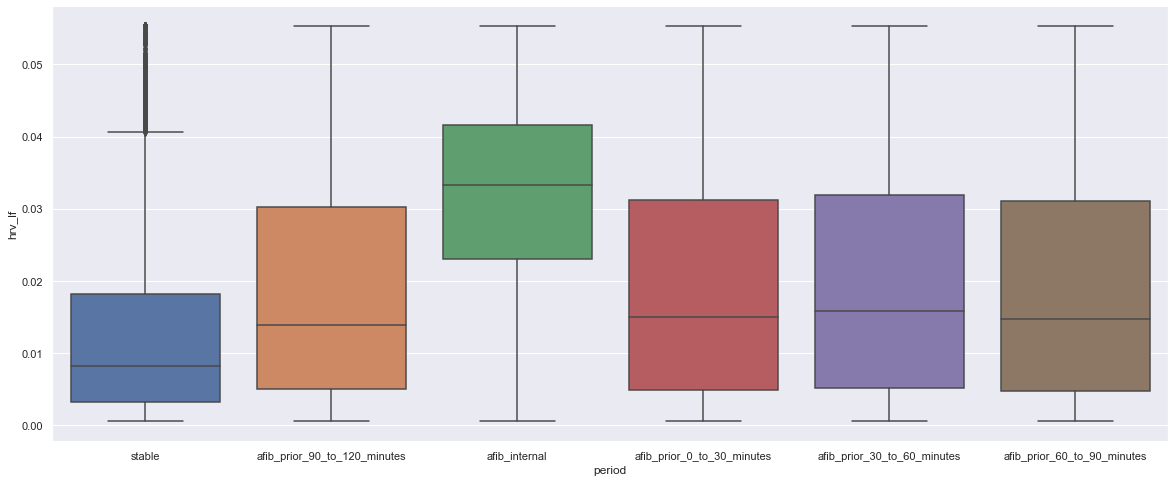

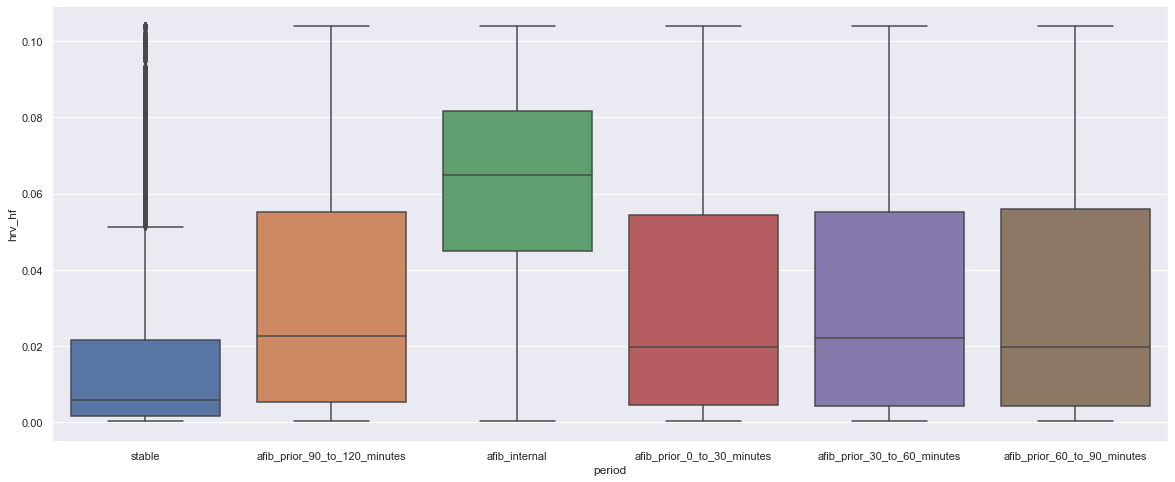

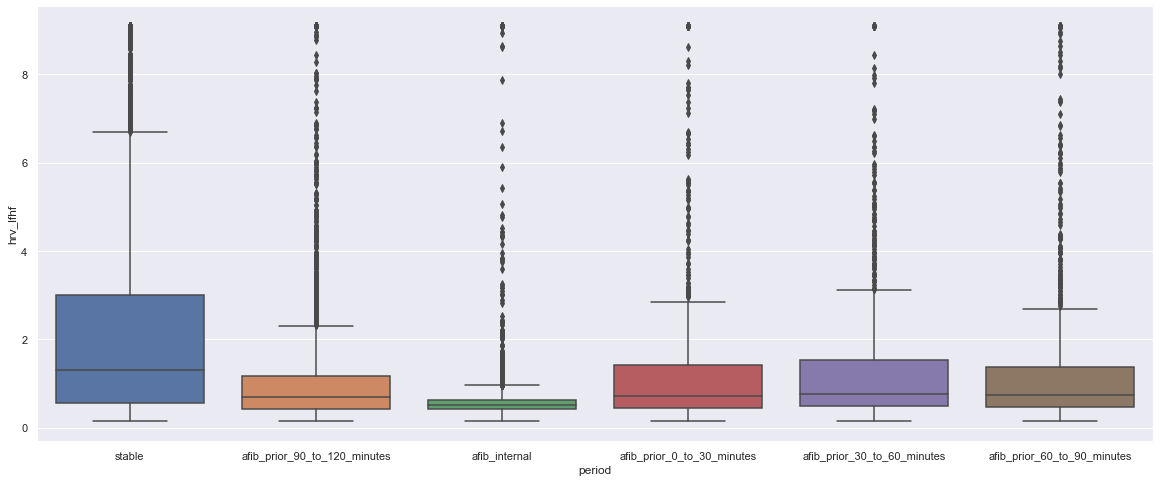

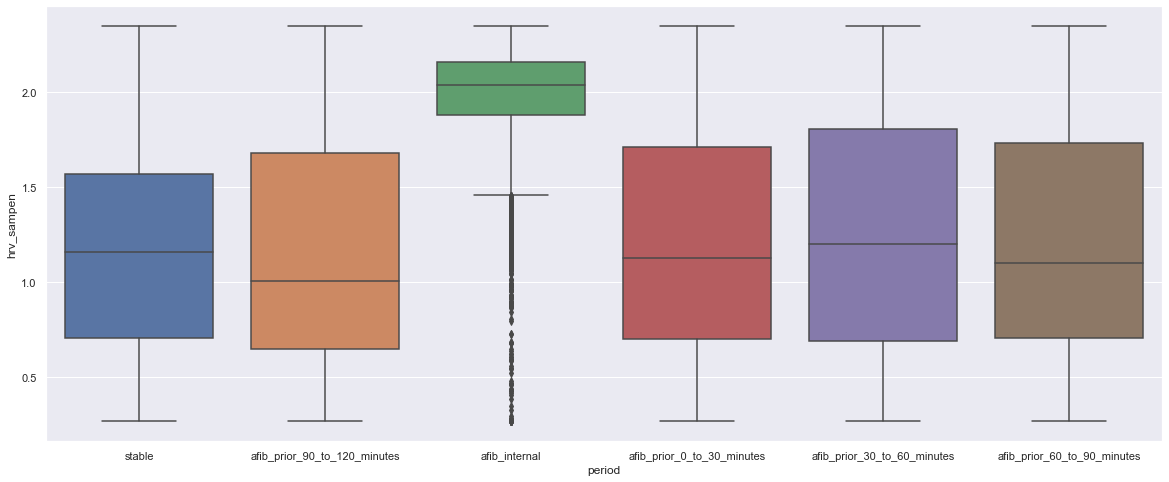

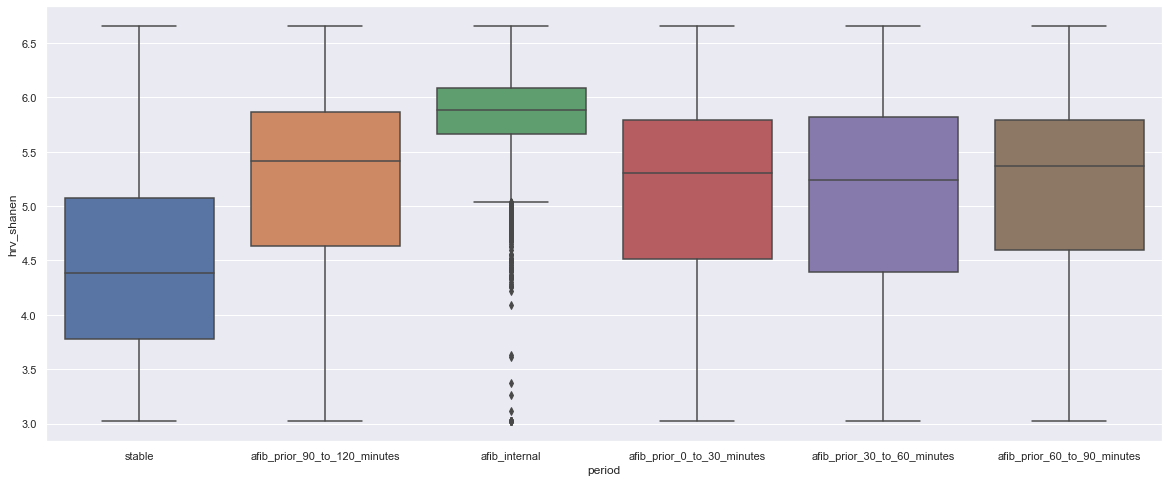

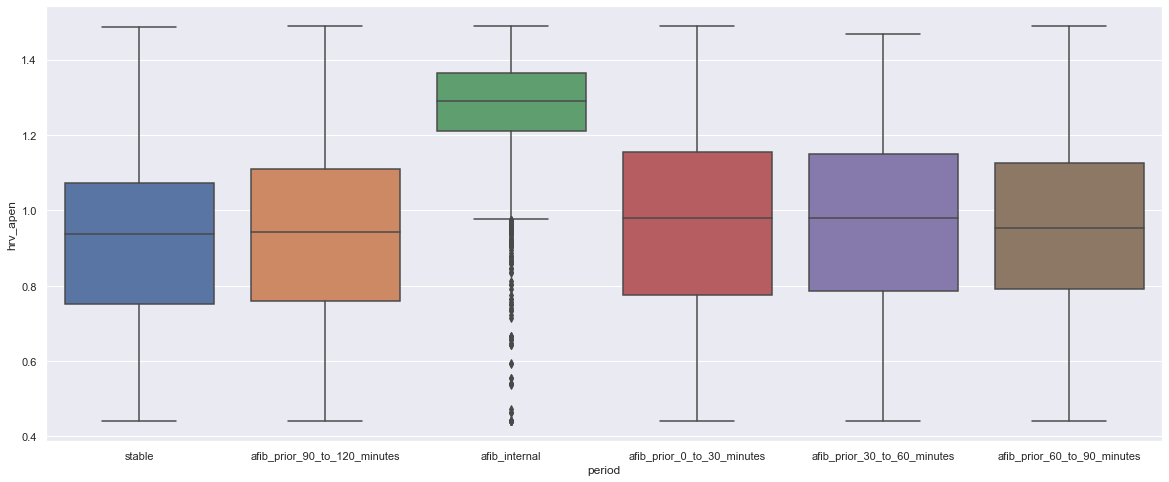

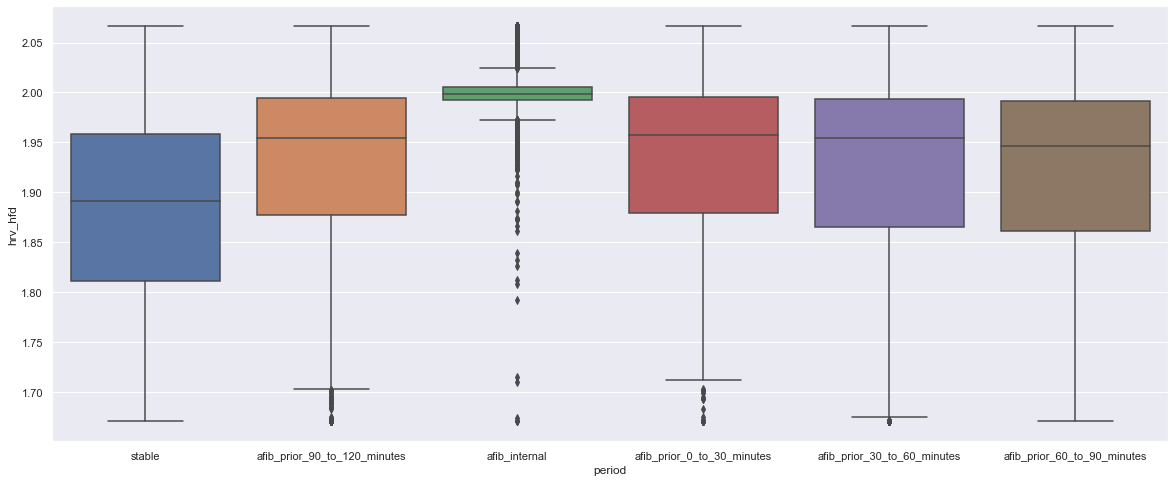

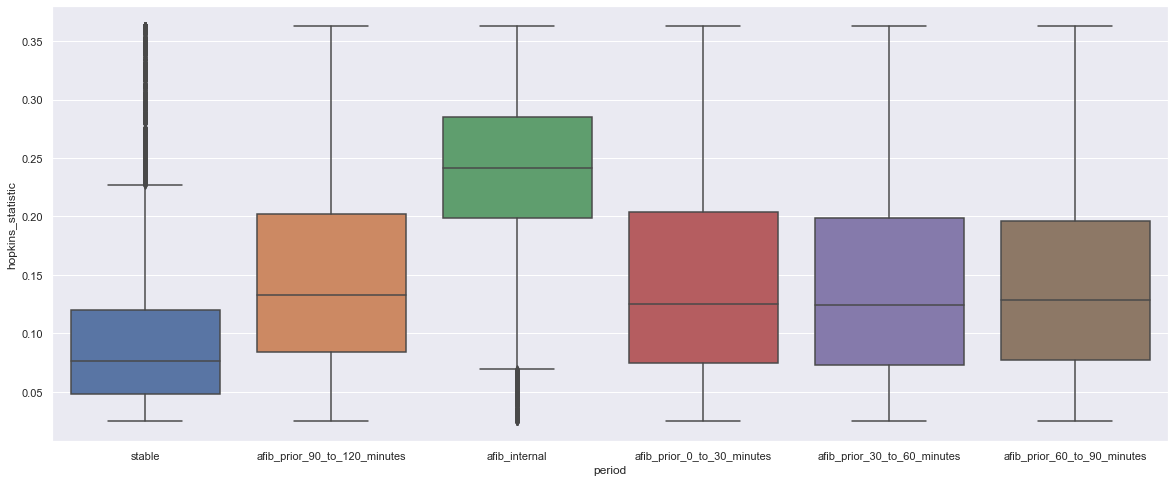

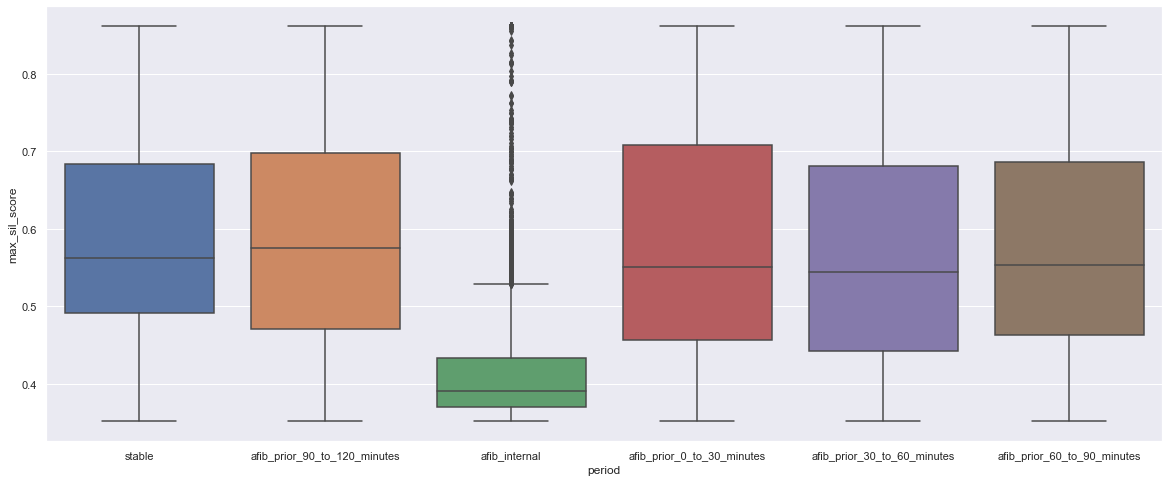

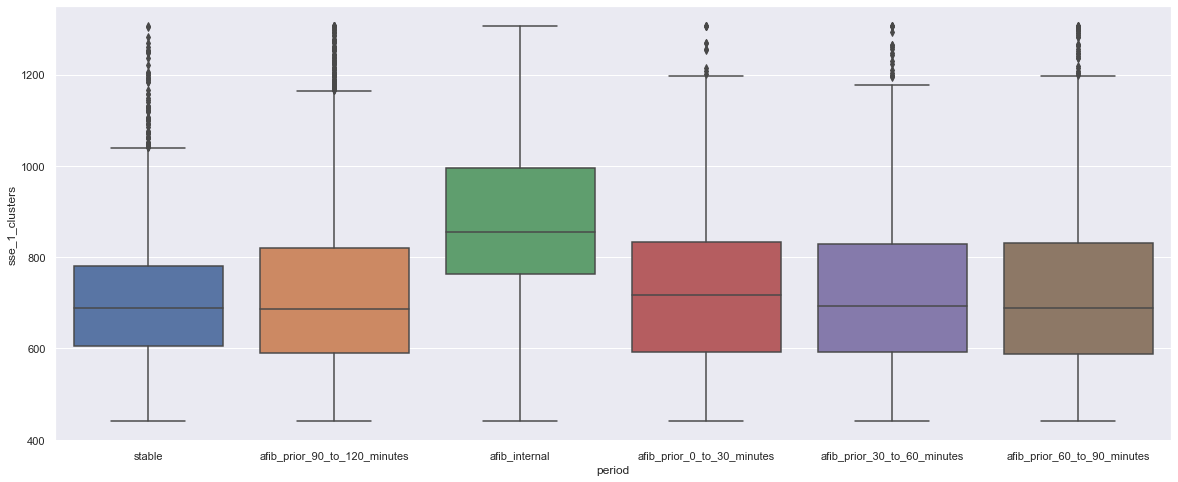

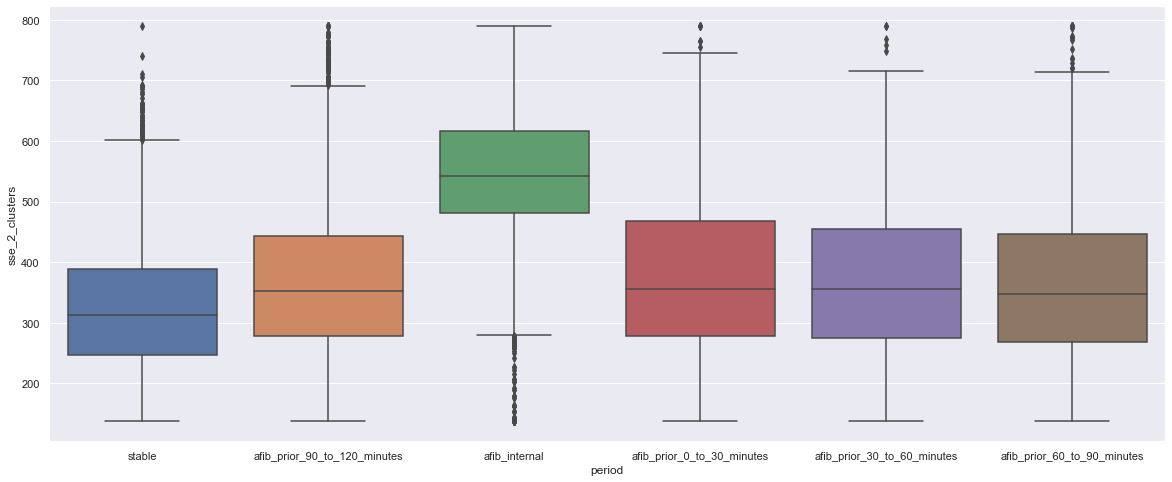

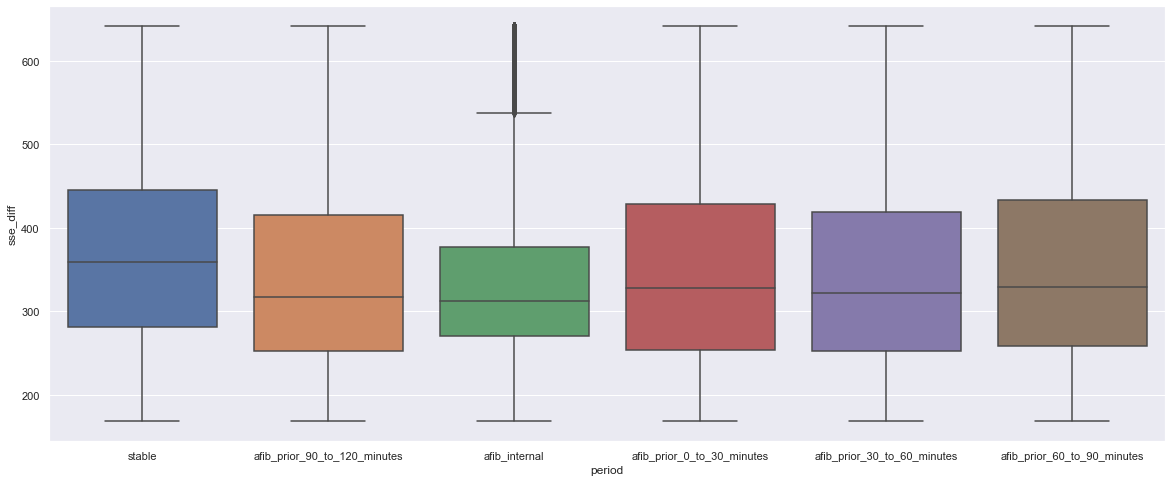

In [31]:
categorizedDF = categorized.copy().drop_duplicates(subset=dataDF.columns, keep='last')
import seaborn as sns
def boxAndWhiskers(feat, df):
    df = df.copy()
    # first winsorize all data
    df[feat] = sp.stats.mstats.winsorize(df[feat], limits=[.02, .02])
    sns.set(rc={'figure.figsize':(20,8)})
    plt.figure()
    sns.boxplot(y=feat, x='period', data=df.reset_index())
    # ax = df.plot(kind='box', x='period', y=feat, title=f'{feat} boxplot organized by period')
    # for period in df['period'].unique():
    #     plt.boxplot(df[df['period'] == period][feat], label=period)
    # plt.title(f'{feat} distribution organized by period')
    # plt.legend()
    # plt.xlabel(feat)
    # plt.show()
from data.utilities import getDataConfig
for feat in getDataConfig().features_nk:
    boxAndWhiskers(feat, categorizedDF.sort_values(by='period'))
